In [2]:
import sqlite3
import pandas as pd


In [1]:
from google.colab import files
uploaded = files.upload()


Saving phishing_dataset (3) (3).db to phishing_dataset (3) (3).db


In [3]:
#create a connection for database file
conn = sqlite3.connect('phishing_dataset (3).db')

In [4]:
cursor = conn.cursor()

In [7]:
# Fetch url_id and domain values
cursor.execute("SELECT city, domain FROM urls WHERE domain IS NOT NULL;")
rows = cursor.fetchall()
print("Total domains to enrich:", len(rows))

Total domains to enrich: 20000


In [10]:
import numpy as np

# Ensure columns exist
try:
    cursor.execute("ALTER TABLE urls ADD COLUMN risk_score REAL;")
    cursor.execute("ALTER TABLE urls ADD COLUMN risk_level TEXT;")
    conn.commit()
except Exception:
    pass

# Load necessary data
df = pd.read_sql_query("""
SELECT url_id, domain, domain_age_days, brand_similarity, fingerprint_sha256
FROM urls;
""", conn)

print(f"Loaded {len(df)} URLs")

# --- Factor 1: Feed frequency (log scale) ---
domain_counts = df['domain'].value_counts()
df['feed_freq'] = df['domain'].map(domain_counts).fillna(1)
df['feed_score'] = np.log1p(df['feed_freq']) / np.log1p(domain_counts.max()) * 25

# --- Factor 2: Domain age (newer domains riskier) ---
max_age = df['domain_age_days'].max(skipna=True) or 1
df['age_score'] = (1 - (df['domain_age_days'].fillna(max_age) / max_age)) * 25
df['age_score'] = df['age_score'].clip(0, 25)

# --- Factor 3: SSL mismatch ---
def ssl_score(fp):
    if pd.isna(fp) or str(fp).strip() == "":
        return 25
    return 5
df['ssl_score'] = df['fingerprint_sha256'].apply(ssl_score)

# --- Factor 4: Brand similarity (auto scale 0–1 or 0–100) ---
def brand_score(sim):
    if sim is None or pd.isna(sim):
        return 10
    sim = float(sim)
    if sim > 1:
        sim /= 100.0
    sim = np.clip(sim, 0, 1)
    return sim * 25
df['brand_score'] = df['brand_similarity'].apply(brand_score)

# --- Combine scores ---
df['risk_score'] = df[['feed_score','age_score','ssl_score','brand_score']].sum(axis=1).clip(0,100)

# --- Classify ---
def risk_level(score):
    if score >= 70:
        return 'High'
    elif score >= 40:
        return 'Medium'
    return 'Low'

df['risk_level'] = df['risk_score'].apply(risk_level)

Loaded 20000 URLs


In [11]:
# --- Write back ---
for i, r in df.iterrows():
    cursor.execute("""
        UPDATE urls
        SET risk_score = ?, risk_level = ?
        WHERE url_id = ?;
    """, (float(r['risk_score']), r['risk_level'], int(r['url_id'])))
    if i % 1000 == 0:
        conn.commit()
        print(f"Updated {i} rows...")

conn.commit()
print("🎯 Updated adaptive risk scoring complete.")

Updated 0 rows...
Updated 1000 rows...
Updated 2000 rows...
Updated 3000 rows...
Updated 4000 rows...
Updated 5000 rows...
Updated 6000 rows...
Updated 7000 rows...
Updated 8000 rows...
Updated 9000 rows...
Updated 10000 rows...
Updated 11000 rows...
Updated 12000 rows...
Updated 13000 rows...
Updated 14000 rows...
Updated 15000 rows...
Updated 16000 rows...
Updated 17000 rows...
Updated 18000 rows...
Updated 19000 rows...
🎯 Updated adaptive risk scoring complete.


In [12]:
cursor.execute("SELECT risk_level, COUNT(*) FROM urls GROUP BY risk_level;")
print(cursor.fetchall())



[('High', 12), ('Low', 9682), ('Medium', 10306)]


In [13]:
df_check = pd.read_sql_query("""
SELECT url, domain_age_days, brand_similarity, risk_score, risk_level
FROM urls
LIMIT 10;
""", conn)
print(df_check)

                                                 url  domain_age_days  \
0     https://sites.google.com/view/porepaotpaeotae/          10257.0   
1  https://us4.campaign-archive.com/?u=0348935425...           6859.0   
2         http://103.144.245.250:2080/02.08.2022.exe              NaN   
3           https://verify-directnew2023.start.page/              NaN   
4                              https://q-r.to/bfT12z           5005.0   
5  https://104.0.237.199:9802/NAS_Public/ken_l/RA...              NaN   
6                                 http://itaucl.link             59.0   
7  http://103.20.213.34:8080/Uploads/Uploads/Arya...              NaN   
8   http://213.209.143.44/010100110101010/x86_32.zip              NaN   
9           http://176.65.148.114/bins/plasma.x86_64           1154.0   

   brand_similarity  risk_score risk_level  
0             100.0   55.913236     Medium  
1              36.0   32.505358        Low  
2               0.0   27.399241        Low  
3              5

In [18]:
# Select rows where risk_level is 'High'
high_df = pd.read_sql_query("""
SELECT *
FROM urls
WHERE risk_level = 'Medium'
ORDER BY risk_score DESC;
""", conn)

# Display the first few
print(f"🔎 Found {len(high_df)} high-risk URLs")
display(high_df.head(10))

🔎 Found 10306 high-risk URLs


,url_id,url,domain,date_added,verified,url_status,label,whois_registrar,creation_date,domain_age_days,...,region,city,fingerprint_sha256,issuer,subject,not_valid_before,not_valid_after,error,risk_score,risk_level
0,4497,http://microsoft-telemetry.cc/iddr/lool.exe,microsoft-telemetry.cc,2025-09-12 05:32:22,None,offline,phishing,"NICENIC INTERNATIONAL GROUP CO., LIMITED",2025-08-16 14:15:43,60.0,...,New York,Buffalo,None,None,None,None,None,no_ssl_for_http,69.697163,Medium
1,4585,http://microsoft-telemetry.cc/iddr/ttt.exe,microsoft-telemetry.cc,2025-09-08 09:49:10,None,offline,phishing,"NICENIC INTERNATIONAL GROUP CO., LIMITED",2025-08-16 14:15:43,60.0,...,New York,Buffalo,None,None,None,None,None,no_ssl_for_http,69.697163,Medium
2,686,http://stormc2.fun/p-p.c-.Sakura,stormc2.fun,2025-09-08 16:09:08,None,offline,phishing,"OVH, SAS",2025-08-31 22:33:10,44.0,...,None,None,None,None,None,None,None,no_ssl_for_http,69.158123,Medium
3,3182,http://stormc2.fun/a-r.m-7.Sakura,stormc2.fun,2025-09-08 16:09:08,None,offline,phishing,"OVH, SAS",2025-08-31 22:33:10,44.0,...,None,None,None,None,None,None,None,no_ssl_for_http,69.158123,Medium
4,7255,http://stormc2.fun/a-r.m-6.Sakura,stormc2.fun,2025-09-08 16:09:12,None,offline,phishing,"OVH, SAS",2025-08-31 22:33:10,44.0,...,None,None,None,None,None,None,None,no_ssl_for_http,69.158123,Medium
5,9986,http://stormc2.fun/s-h.4-.Sakura,stormc2.fun,2025-09-08 16:09:08,None,offline,phishing,"OVH, SAS",2025-08-31 22:33:10,44.0,...,None,None,None,None,None,None,None,no_ssl_for_http,69.158123,Medium
6,15613,http://stormc2.fun/i-5.8-6.Sakura,stormc2.fun,2025-09-08 16:09:09,None,offline,phishing,"OVH, SAS",2025-08-31 22:33:10,45.0,...,None,None,None,None,None,None,None,no_ssl_for_http,69.156364,Medium
7,19347,http://stormc2.fun/m-6.8-k.Sakura,stormc2.fun,2025-09-08 16:09:18,None,offline,phishing,"OVH, SAS",2025-08-31 22:33:10,45.0,...,None,None,None,None,None,None,None,no_ssl_for_http,69.156364,Medium
8,16701,https://revenue.paytia.cc/notice,revenue.paytia.cc,2025-09-26T13:29:44+00:00,yes,None,phishing,"NameSilo, LLC",2025-09-25 10:52:48,20.0,...,None,None,None,None,None,None,None,[Errno -2] Name or service not known,69.114060,Medium
9,18698,https://mail.tra.gov.om.microsft-online.com/,mail.tra.gov.om.microsft-online.com,2025-09-30T09:30:17+00:00,yes,None,phishing,"Cloudflare, Inc.",2025-09-25 04:27:10,20.0,...,None,Singapore,None,None,None,None,None,[SSL: CERTIFICATE_VERIFY_FAILED] certificate v...,69.114060,Medium


In [17]:


# Drop the unwanted columns
cursor.executescript("""
ALTER TABLE urls DROP COLUMN asn;
ALTER TABLE urls DROP COLUMN asn_description;
ALTER TABLE urls DROP COLUMN asn_reputation;
""")

conn.commit()

print("✅ Columns (asn, asn_description, asn_reputation) dropped successfully.")


✅ Columns (asn, asn_description, asn_reputation) dropped successfully.


In [35]:
df = pd.read_sql_query("SELECT url FROM urls", conn)
df.head(20)



,url
0,https://sites.google.com/view/porepaotpaeotae/
1,https://us4.campaign-archive.com/?u=0348935425...
2,http://103.144.245.250:2080/02.08.2022.exe
3,https://verify-directnew2023.start.page/
4,https://q-r.to/bfT12z
5,https://104.0.237.199:9802/NAS_Public/ken_l/RA...
6,http://itaucl.link
7,http://103.20.213.34:8080/Uploads/Uploads/Arya...
8,http://213.209.143.44/010100110101010/x86_32.zip
9,http://176.65.148.114/bins/plasma.x86_64


**Campaigns**

In [22]:
# # Load the relevant tables
# urls_df = pd.read_sql_query("""
# SELECT url_id, url, whois_registrar, fingerprint_sha256, ip, risk_score
# FROM urls;
# """, conn)

# reports_df = pd.read_sql_query("""
# SELECT url_id, target
# FROM reports;
# """, conn)


In [23]:
# # Merge to bring brand info alongside each URL
# merged_df = pd.merge(urls_df, reports_df, on="url_id", how="left")

In [32]:
# print(f"✅ Loaded {len(merged_df)} enriched URLs with brand info")

✅ Loaded 20001 enriched URLs with brand info


In [24]:
# merged_df.head(10)

,url_id,url,whois_registrar,fingerprint_sha256,ip,risk_score,target
0,1,https://sites.google.com/view/porepaotpaeotae/,"MarkMonitor, Inc.",CA9418CF3D99B250172EEC63BDBE46034AECABBCCC1573...,142.250.152.102,55.913236,Other
1,2,https://us4.campaign-archive.com/?u=0348935425...,MarkMonitor Inc.,86FBCC05C66537AEC970F6DD8D9341ED535483E0CD1F2F...,104.68.250.123,32.505358,Other
2,3,http://103.144.245.250:2080/02.08.2022.exe,None,None,None,27.399241,None
3,4,https://verify-directnew2023.start.page/,None,89F2D132191795BE560C953C7F023FD2435869AA6181DA...,104.18.24.210,21.649241,Facebook
4,5,https://q-r.to/bfT12z,Government of Kingdom of Tonga,8A045C6DBB0BE139FA7F2AF9C89D8A55DEB4FD4A90012D...,3.167.163.129,46.418710,Other
5,6,https://104.0.237.199:9802/NAS_Public/ken_l/RA...,None,None,None,45.606400,None
6,7,http://itaucl.link,Dominet (HK) Limited,None,8.219.196.149,62.295456,Other
7,8,http://103.20.213.34:8080/Uploads/Uploads/Arya...,None,None,None,47.660871,None
8,9,http://213.209.143.44/010100110101010/x86_32.zip,None,None,213.209.143.44,41.075972,None
9,10,http://176.65.148.114/bins/plasma.x86_64,"Cloudflare, Inc",None,176.65.148.114,53.540891,None


In [5]:
# print("=== Basic Info ===")
# print(merged_df.info())
# print("\nTotal Rows:", len(merged_df))


In [30]:
# for col in merged_df.columns:
#     print(f"📊 Column: {col}")
#     print(f"➡️  Unique values: {merged_df[col].nunique(dropna=False)}")

#     # Show top 10 most frequent values (including NaN)
#     print(merged_df[col].value_counts(dropna=False).head(10))
#     print("-" * 30)


📊 Column: url_id
➡️  Unique values: 20000
url_id
5494     2
13338    1
13337    1
13336    1
13335    1
13334    1
13333    1
13332    1
13321    1
13330    1
Name: count, dtype: int64
------------------------------
📊 Column: url
➡️  Unique values: 19999
url
https://broadbandqew.weebly.com/                                                                                                                                                  3
https://ithelpdesk-uc.weebly.com/                                                                                                                                                 1
https://esssschhh.blogspot.com/?m=0                                                                                                                                               1
http://178.16.54.200/files/6394836594/eFYM9KD.exe                                                                                                                                 1
https://docs.google.c

In [29]:
# # Fill missing values
# merged_df = merged_df.fillna("unknown")

In [6]:
query = """
SELECT u.url_id, u.url, u.whois_registrar, u.fingerprint_sha256, u.ip,
       u.risk_score, r.target
FROM urls u
LEFT JOIN reports r ON u.url_id = r.url_id
WHERE u.whois_registrar IS NOT NULL
   OR u.fingerprint_sha256 IS NOT NULL
   OR u.ip IS NOT NULL;
"""
df = pd.read_sql_query(query, conn)
print(f"✅ Loaded {len(df)} enriched URLs with brand info")
df.head()


✅ Loaded 13912 enriched URLs with brand info


,url_id,url,whois_registrar,fingerprint_sha256,ip,risk_score,target
0,1,https://sites.google.com/view/porepaotpaeotae/,"MarkMonitor, Inc.",CA9418CF3D99B250172EEC63BDBE46034AECABBCCC1573...,142.250.152.102,55.913236,google
1,2,https://us4.campaign-archive.com/?u=0348935425...,MarkMonitor Inc.,86FBCC05C66537AEC970F6DD8D9341ED535483E0CD1F2F...,104.68.250.123,32.505358,None
2,4,https://verify-directnew2023.start.page/,None,89F2D132191795BE560C953C7F023FD2435869AA6181DA...,104.18.24.210,21.649241,Facebook
3,5,https://q-r.to/bfT12z,Government of Kingdom of Tonga,8A045C6DBB0BE139FA7F2AF9C89D8A55DEB4FD4A90012D...,3.167.163.129,46.418710,None
4,7,http://itaucl.link,Dominet (HK) Limited,None,8.219.196.149,62.295456,None


In [8]:
df.head()

,url_id,url,whois_registrar,fingerprint_sha256,ip,risk_score,target
0,1,https://sites.google.com/view/porepaotpaeotae/,"MarkMonitor, Inc.",CA9418CF3D99B250172EEC63BDBE46034AECABBCCC1573...,142.250.152.102,55.913236,google
1,2,https://us4.campaign-archive.com/?u=0348935425...,MarkMonitor Inc.,86FBCC05C66537AEC970F6DD8D9341ED535483E0CD1F2F...,104.68.250.123,32.505358,unknown
2,4,https://verify-directnew2023.start.page/,unknown,89F2D132191795BE560C953C7F023FD2435869AA6181DA...,104.18.24.210,21.649241,Facebook
3,5,https://q-r.to/bfT12z,Government of Kingdom of Tonga,8A045C6DBB0BE139FA7F2AF9C89D8A55DEB4FD4A90012D...,3.167.163.129,46.418710,unknown
4,7,http://itaucl.link,Dominet (HK) Limited,unknown,8.219.196.149,62.295456,unknown


In [7]:
df = df.fillna("unknown")

# Normalize placeholder values
df["whois_registrar"].replace(["None", ""], "unknown", inplace=True)
df["fingerprint_sha256"].replace(["None", ""], "unknown", inplace=True)
df["ip"].replace(["None", ""], "unknown", inplace=True)
df["target"].replace(["None", "Other", ""], "unknown", inplace=True)


/tmp/ipython-input-3812426650.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["whois_registrar"].replace(["None", ""], "unknown", inplace=True)
/tmp/ipython-input-3812426650.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

In [9]:
# for col in df.columns:
#     print(f"📊 Column: {col}")
#     print(f"➡️  Unique values: {merged_df[col].nunique(dropna=False)}")

#     # Show top 10 most frequent values (including NaN)
#     print(df[col].value_counts(dropna=False).head(30))
#     print("-" * 30)


📊 Column: url_id


NameError: name 'merged_df' is not defined

In [10]:
# Exclude URLs that have no meaningful infra data (avoid fake campaigns)
df = df[
    ~(
        (df["whois_registrar"] == "unknown") &
        (df["fingerprint_sha256"] == "unknown") &
        (df["ip"] == "unknown")
    )
].copy()

print(f"✅ {len(df)} URLs remain after excluding unknown infrastructure")

✅ 13912 URLs remain after excluding unknown infrastructure


In [11]:
df["campaign_key"] = df.apply(
    lambda row: f"{row['whois_registrar']}|{row['fingerprint_sha256']}|{row['ip']}",
    axis=1
)


In [12]:
campaigns_df = (
    df.groupby("campaign_key")
    .agg(
        total_urls=("url_id", "count"),
        avg_risk=("risk_score", "mean"),
        registrars=("whois_registrar", lambda x: ", ".join(sorted(set(x)))),
        fingerprints=("fingerprint_sha256", lambda x: ", ".join(sorted(set(x)))),
        ips=("ip", lambda x: ", ".join(sorted(set(x)))),
        targeted_brands=("target", lambda x: ", ".join(sorted(set(filter(lambda v: v != 'unknown', x)))))
    )
    .reset_index()
)

# Remove rows where all three fields are unknown or null
df_filtered = df[
    ~(
        (df["whois_registrar"].isin(["unknown", None, ""])) &
        (df["fingerprint_sha256"].isin(["unknown", None, ""])) &
        (df["ip"].isin(["unknown", None, ""]))
    )
].copy()

# Then create the campaign key
df_filtered["campaign_key"] = df_filtered.apply(
    lambda row: f"{row['whois_registrar']}|{row['fingerprint_sha256']}|{row['ip']}",
    axis=1
)


In [13]:
# Keep only campaign groups with more than one URL
campaigns_df = campaigns_df[campaigns_df["total_urls"] > 1].reset_index(drop=True)


In [118]:
campaigns_df.head(30)



,campaign_key,total_urls,avg_risk,registrars,fingerprints,ips,targeted_brands
0,1 Api GmbH|6BDF43B6140129888B748B2F9E6D3B1CB51...,2,43.127716,1 Api GmbH,6BDF43B6140129888B748B2F9E6D3B1CB5191941E0A229...,172.64.149.159,
1,1 Api GmbH|B829763E8EDF6AC70DC4534CAFEDF70556A...,4,44.549834,1 Api GmbH,B829763E8EDF6AC70DC4534CAFEDF70556A4387D403265...,199.36.158.100,
2,1 Api GmbH|unknown|172.64.149.159,2,63.127716,1 Api GmbH,unknown,172.64.149.159,
3,101domain GRS Limited|17396227EE5286BF94E92FED...,2,34.265764,101domain GRS Limited,17396227EE5286BF94E92FEDA10EBD7EE429D33BE1EBC8...,104.21.43.235,UniCredit
4,123-Reg Limited|4CFB24BDF8F7AC8F5AD7AFC0F6BEBF...,19,33.075571,123-Reg Limited,4CFB24BDF8F7AC8F5AD7AFC0F6BEBFEB3C7E3A8202EF07...,34.147.200.198,"aws, td, x"
5,123-Reg Limited|BAD80B63A2F4D6DB983C65AD0B0CD4...,3,28.947840,123-Reg Limited,BAD80B63A2F4D6DB983C65AD0B0CD4E2C01F39ED0208BE...,45.33.29.14,
6,123-Reg Limited|unknown|45.33.29.14,2,49.181751,123-Reg Limited,unknown,45.33.29.14,
7,1API GmbH|1443F8C917ABC20EBEB8B457CCC8EB568E7A...,4,34.527795,1API GmbH,1443F8C917ABC20EBEB8B457CCC8EB568E7A5096FDE27D...,172.64.146.87,x
8,1API GmbH|54F84C64ABBD6F0E38393AF06F4B197C4500...,3,34.856251,1API GmbH,54F84C64ABBD6F0E38393AF06F4B197C4500D2AB53CD78...,104.20.3.253,
9,1API GmbH|7C06B67574475853C8152C538E6BD02AB964...,7,29.412402,1API GmbH,7C06B67574475853C8152C538E6BD02AB964803985031A...,199.232.211.52,"DocuSign, Optus"


In [14]:
for col in campaigns_df.columns:
    print(f"📊 Column: {col}")
    print(f"➡️  Unique values: {campaigns_df[col].nunique(dropna=False)}")

    # Show top 10 most frequent values (including NaN)
    print(campaigns_df[col].value_counts(dropna=False).head(10))
    print("-" * 30)


📊 Column: campaign_key
➡️  Unique values: 951
campaign_key
邦宁数字技术股份有限公司|unknown|unknown                                                                            1
1 Api GmbH|6BDF43B6140129888B748B2F9E6D3B1CB5191941E0A229A8350023EEE2FD54D6|172.64.149.159              1
1 Api GmbH|B829763E8EDF6AC70DC4534CAFEDF70556A4387D40326541CCC558C78A5A1640|199.36.158.100              1
1 Api GmbH|unknown|172.64.149.159                                                                       1
101domain GRS Limited|17396227EE5286BF94E92FEDA10EBD7EE429D33BE1EBC89D044B88A2ED7D774D|104.21.43.235    1
123-Reg Limited|4CFB24BDF8F7AC8F5AD7AFC0F6BEBFEB3C7E3A8202EF0701754F4AB9C7A69B6C|34.147.200.198         1
123-Reg Limited|BAD80B63A2F4D6DB983C65AD0B0CD4E2C01F39ED0208BEE3A5DE29A3F5695F87|45.33.29.14            1
unknown|unknown|91.92.240.220                                                                           1
unknown|unknown|91.92.240.104                                                                

In [27]:
for platform in HOSTING_PLATFORMS:
    cursor.execute("""
        UPDATE reports
        SET target = 'other'
        WHERE LOWER(target) = ?;
    """, (platform.lower(),))

conn.commit()
print("✅ Replaced hosting platform targets with 'other'")


✅ Replaced hosting platform targets with 'other'


In [28]:
cursor.execute("""
SELECT reports.report_id, urls.url
FROM reports
JOIN urls ON reports.url_id = urls.url_id
WHERE reports.target IS NULL OR reports.target = 'other';
""")
rows_to_update = cursor.fetchall()

print(f"🎯 {len(rows_to_update)} rows need new target enrichment.")


🎯 15983 rows need new target enrichment.


In [29]:
import time

for i, (report_id, url) in enumerate(rows_to_update, start=1):
    new_target = predict_target_brand(url)
    cursor.execute("""
        UPDATE reports
        SET target = ?
        WHERE report_id = ?;
    """, (new_target, report_id))

    if i % 100 == 0:
        conn.commit()
        print(f"✅ Updated {i} records...")


conn.commit()
print("🎯 Target enrichment re-run completed successfully!")



✅ Updated 100 records...
✅ Updated 200 records...
✅ Updated 300 records...
✅ Updated 400 records...
✅ Updated 500 records...
✅ Updated 600 records...
✅ Updated 700 records...
✅ Updated 800 records...
✅ Updated 900 records...
✅ Updated 1000 records...
✅ Updated 1100 records...
✅ Updated 1200 records...
✅ Updated 1300 records...
✅ Updated 1400 records...
✅ Updated 1500 records...
✅ Updated 1600 records...
✅ Updated 1700 records...
✅ Updated 1800 records...
✅ Updated 1900 records...
✅ Updated 2000 records...
✅ Updated 2100 records...
✅ Updated 2200 records...
✅ Updated 2300 records...
✅ Updated 2400 records...
✅ Updated 2500 records...
✅ Updated 2600 records...
✅ Updated 2700 records...
✅ Updated 2800 records...
✅ Updated 2900 records...
✅ Updated 3000 records...
✅ Updated 3100 records...
✅ Updated 3200 records...
✅ Updated 3300 records...
✅ Updated 3400 records...
✅ Updated 3500 records...
✅ Updated 3600 records...
✅ Updated 3700 records...
✅ Updated 3800 records...
✅ Updated 3900 record

In [30]:
df = pd.read_sql_query("""
SELECT target, COUNT(*) AS count
FROM reports
GROUP BY target
ORDER BY count DESC
LIMIT 20;
""", conn)
display(df)


,target,count
0,None,15964
1,google,1637
2,x,717
3,Allegro,271
4,adobe,224
5,Internal Revenue Service,214
6,dropbox,146
7,Facebook,55
8,square,51
9,td,49


🎯 Top Targeted Brands:


,target,count
0,google,1637
1,x,717
2,Allegro,271
3,adobe,224
4,Internal Revenue Service,214
5,dropbox,146
6,Facebook,55
7,square,51
8,td,49
9,Microsoft,47


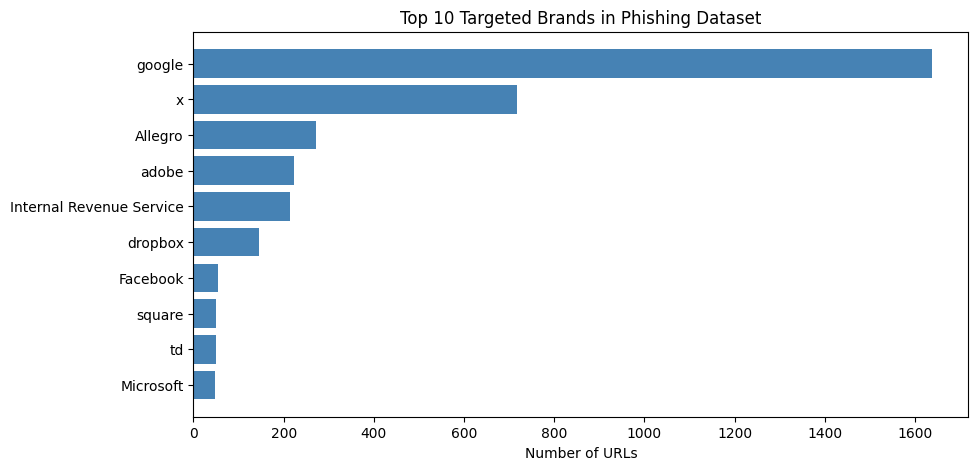

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Query brand frequencies
df_brands = pd.read_sql_query("""
SELECT
    target,
    COUNT(*) AS count
FROM reports
WHERE target IS NOT NULL AND target != ''
GROUP BY target
ORDER BY count DESC
LIMIT 10;
""", conn)

# Display data
print("🎯 Top Targeted Brands:")
display(df_brands)

# Plot
plt.figure(figsize=(10,5))
plt.barh(df_brands['target'], df_brands['count'], color='steelblue')
plt.gca().invert_yaxis()
plt.title("Top 10 Targeted Brands in Phishing Dataset")
plt.xlabel("Number of URLs")
plt.show()


In [34]:
# df_campaigns = pd.read_sql_query("""
# SELECT
#     domain,
#     target,
#     COUNT(*) AS num_urls
# FROM reports
# JOIN urls ON reports.url_id = urls.url_id
# WHERE target IS NOT NULL
# GROUP BY domain, target
# HAVING num_urls > 5
# ORDER BY num_urls DESC
# LIMIT 20;
# """, conn)

# print("🔥 Trending Campaigns (domain + brand combinations):")
# display(df_campaigns)


import pandas as pd
import matplotlib.pyplot as plt


# Query campaigns with only average risk score
df_campaigns = pd.read_sql_query("""
SELECT
    u.domain,
    r.target,
    AVG(u.risk_score) AS avg_risk_score
FROM urls u
JOIN reports r ON u.url_id = r.url_id
WHERE r.target IS NOT NULL AND r.target != ''
GROUP BY u.domain, r.target
HAVING COUNT(u.url_id) > 3
ORDER BY avg_risk_score DESC
LIMIT 15;
""", conn)

# Display top campaigns
print("🔥 Trending Campaigns (with Average Risk Score):")
display(df_campaigns)


🔥 Trending Campaigns (with Average Risk Score):


,domain,target,avg_risk_score
0,prostreamx.xyz,x,68.451460
1,of.xkqi8.ru,x,67.523388
2,mx.puva6ey2.ru,x,66.880531
3,allahmisin.musallat.xyz,x,65.381737
4,voxelnodes.in,x,64.974117
5,devilnet.xyz,x,64.777522
6,www.doxxingservices.shop,x,64.232912
7,wrxcnc.com,x,62.121599
8,docs.google.com,google,61.971887
9,docs.google.com,Internal Revenue Service,61.957149


**Target**

In [17]:
!pip install python-Levenshtein tldextract

import re
import tldextract
import Levenshtein
from urllib.parse import urlparse
import sqlite3
import pandas as pd

BRANDS = [
    # 🌐 Global tech & email services
    "google", "gmail", "facebook", "instagram", "whatsapp", "tiktok", "linkedin",
    "twitter", "x", "snapchat", "reddit", "youtube", "zoom", "skype", "discord",
    "telegram", "icloud", "apple", "microsoft", "office365", "outlook", "hotmail",
    "yahoo", "aol", "protonmail", "zoho", "yandex", "mailchimp", "weebly",
    "wordpress", "shopify", "wix", "dropbox", "mega", "adobe", "canva",

    # 🏦 Banking & finance
    "paypal", "chase", "bankofamerica", "wellsfargo", "citibank", "americanexpress",
    "barclays", "hsbc", "lloyds", "natwest", "santander", "revolut", "monzo",
    "wise", "transferwise", "stripe", "square", "intuit", "mint", "zelle",
    "venmo", "cashapp", "revolut", "rbc", "td", "bmo", "scotiabank", "capitalone",
    "creditkarma", "discover", "boa", "firstdirect", "postfinance", "pnc", "regions",
    "visa", "mastercard", "westernunion", "moneygram", "worldremit", "paypaluk",

    # 🛍️ E-commerce, logistics & retail
    "amazon", "ebay", "alibaba", "aliexpress", "etsy", "walmart", "bestbuy",
    "target", "costco", "home depot", "lowes", "carrefour", "flipkart",
    "mercadolibre", "shopify", "shein", "ubereats", "doordash", "deliveroo",
    "dhl", "ups", "fedex", "usps", "canadapost", "royalmail", "dpd", "hermes",

    # 💼 Enterprise & cloud services
    "aws", "azure", "digitalocean", "cloudflare", "salesforce", "oracle",
    "github", "gitlab", "bitbucket", "atlassian", "jira", "confluence",

    # 🧾 Government / education / utilities
    "irs", "hmrc", "govuk", "uscis", "uscg", "ssa", "revenue", "canada",
    "australia", "mygov", "gov", "tax", "edu", "university", "school",

    # 🎮 Entertainment & streaming
    "netflix", "spotify", "disney", "hulu", "primevideo", "crunchyroll", "twitch",

    # 🧳 Travel & airlines
    "airbnb", "booking", "expedia", "hotels", "qatarairways", "emirates",
    "britishairways", "delta", "united", "ryanair", "easyjet", "lufthansa",
    "uber", "lyft", "bolt",

    # 🩺 Health / insurance
    "aetna", "cigna", "unitedhealth", "bluecross", "medicare", "medicaid",
    "allstate", "geico", "progressive", "statefarm",

    "vodafone", "etisalat", "orange", "instapay", "banquemisr", "cib", "qnb",
    "nbd", "ahli", "alrajhi", "riyadbank", "stcpay", "emiratesnbd", "paypal",
    "appleid", "icloud", "gov", "mygov", "outlook", "office", "bank"
]



In [18]:
def normalize_domain(domain_or_url):
    """Extract domain + sld (second-level domain)."""
    if domain_or_url.startswith("http://") or domain_or_url.startswith("https://"):
        parsed = urlparse(domain_or_url)
        hostname = parsed.hostname or domain_or_url
    else:
        hostname = domain_or_url
    ext = tldextract.extract(hostname)
    sld = ext.domain
    full = ".".join(part for part in [ext.subdomain, ext.domain, ext.suffix] if part)
    return full, sld

def domain_similarity(sld, brand):
    """Compute normalized similarity (0-1) between SLD and brand."""
    if not sld or not brand:
        return 0.0
    dist = Levenshtein.distance(sld.lower(), brand.lower())
    maxlen = max(len(sld), len(brand))
    return round(1 - (dist / maxlen), 3)

def brand_in_url(url, brand):
    """Check if brand keyword appears in subdomain or path."""
    parsed = urlparse(url if url.startswith("http") else "http://" + url)
    text = " ".join(filter(None, [parsed.hostname, parsed.path])).lower()
    return brand.lower() in text


In [19]:
def predict_target_brand(url, brands=BRANDS, threshold=0.7):
    """Predict likely target brand from URL, ignoring hosting platforms."""
    full, sld = normalize_domain(url)
    best_brand, best_score = None, 0.0

    for b in brands:
        sim = domain_similarity(sld, b)
        if sim > best_score:
            best_brand, best_score = b, sim

        # Boost score if brand keyword appears in subdomain/path
        if brand_in_url(full, b):
            best_brand, best_score = b, max(best_score, 0.9)

    # ⛔ Ignore if the detected brand is a hosting provider
    if best_brand in HOSTING_PLATFORMS:
        best_brand = None
        best_score = 0.0

    # Return brand only if confident enough
    if best_score >= threshold:
        return best_brand
    return None


In [20]:
# Connect to your DB
conn = sqlite3.connect("phishing_dataset (3).db")
cursor = conn.cursor()


In [21]:

# Select rows with missing targets
rows = cursor.execute("""
SELECT r.report_id, u.url
FROM reports r
JOIN urls u ON r.url_id = u.url_id
WHERE r.target IS NULL OR r.target = '' OR r.target = 'Other';
""").fetchall()

print(f"🔍 Found {len(rows)} reports with missing target values.")


🔍 Found 15141 reports with missing target values.


In [25]:
for i, (report_id, url) in enumerate(rows, start=1):
    predicted_brand = predict_target_brand(url)
    cursor.execute("""
        UPDATE reports
        SET target = ?
        WHERE report_id = ?;
    """, (predicted_brand, report_id))

    if i % 100 == 0:
        conn.commit()
        print(f"✅ Processed {i} rows...")

conn.commit()
print("🎯 Target brand enrichment completed successfully!")


✅ Processed 100 rows...
✅ Processed 200 rows...
✅ Processed 300 rows...
✅ Processed 400 rows...
✅ Processed 500 rows...
✅ Processed 600 rows...
✅ Processed 700 rows...
✅ Processed 800 rows...
✅ Processed 900 rows...
✅ Processed 1000 rows...
✅ Processed 1100 rows...
✅ Processed 1200 rows...
✅ Processed 1300 rows...
✅ Processed 1400 rows...
✅ Processed 1500 rows...
✅ Processed 1600 rows...
✅ Processed 1700 rows...
✅ Processed 1800 rows...
✅ Processed 1900 rows...
✅ Processed 2000 rows...
✅ Processed 2100 rows...
✅ Processed 2200 rows...
✅ Processed 2300 rows...
✅ Processed 2400 rows...
✅ Processed 2500 rows...
✅ Processed 2600 rows...
✅ Processed 2700 rows...
✅ Processed 2800 rows...
✅ Processed 2900 rows...
✅ Processed 3000 rows...
✅ Processed 3100 rows...
✅ Processed 3200 rows...
✅ Processed 3300 rows...
✅ Processed 3400 rows...
✅ Processed 3500 rows...
✅ Processed 3600 rows...
✅ Processed 3700 rows...
✅ Processed 3800 rows...
✅ Processed 3900 rows...
✅ Processed 4000 rows...
✅ Process

In [26]:
df_check = pd.read_sql_query("""
SELECT target, COUNT(*) as count
FROM reports
GROUP BY target
ORDER BY count DESC
LIMIT 40;
""", conn)
df_check


,target,count
0,None,15141
1,google,1637
2,other,842
3,x,717
4,Allegro,271
5,adobe,224
6,Internal Revenue Service,214
7,dropbox,146
8,Facebook,55
9,square,51


In [23]:
BRANDS += [
    "vodafone", "etisalat", "orange", "instapay", "banquemisr", "cib", "qnb",
    "nbd", "ahli", "alrajhi", "riyadbank", "stcpay", "emiratesnbd", "paypal",
    "appleid", "icloud", "gov", "mygov", "outlook", "office", "bank"
]


In [24]:
HOSTING_PLATFORMS = {"weebly", "wix", "wordpress", "cloudflare", "blogspot", "github", "000webhost", "netlify"}


In [92]:
import pandas as pd

query = """
SELECT
    target,
    COUNT(*) AS count
FROM reports
GROUP BY target
ORDER BY count DESC;
"""

df_counts = pd.read_sql_query(query, conn)
df_counts


,target,count
0,None,15005
1,google,1637
2,weebly,732
3,x,717
4,Allegro,271
...,...,...
126,Australian Taxation Office,1
127,Aetna Health Plans &amp; Dental Coverage,1
128,AbonnÃ© Free Mobile,1
129,AOL,1


**Brand Similarity**

In [93]:
cursor.execute("ALTER TABLE urls DROP COLUMN brand_similarity;")
conn.commit()

print("✅ Column 'brand_similarity' dropped successfully!")

✅ Column 'brand_similarity' dropped successfully!


In [94]:
query = "PRAGMA table_info(urls);"
columns = pd.read_sql(query, conn)
print(columns)

    cid                name     type  notnull dflt_value  pk
0     0              url_id  INTEGER        0       None   1
1     1                 url     TEXT        0       None   0
2     2              domain     TEXT        0       None   0
3     3          date_added     TEXT        0       None   0
4     4            verified     TEXT        0       None   0
5     5          url_status     TEXT        0       None   0
6     6               label     TEXT        0       None   0
7     7     whois_registrar     TEXT        0       None   0
8     8       creation_date     TEXT        0       None   0
9     9     domain_age_days  INTEGER        0       None   0
10   10         domain_name     TEXT        0       None   0
11   11                  ip     TEXT        0       None   0
12   12             country     TEXT        0       None   0
13   13              region     TEXT        0       None   0
14   14                city     TEXT        0       None   0
15   15  fingerprint_sha

In [95]:
!pip install tldextract

In [96]:
import tldextract
import pandas as pd

df = pd.read_sql("SELECT url_id, url FROM urls;", conn)

# Extract domain parts
df["domain_name"] = df["url"].apply(lambda x:
    f"{tldextract.extract(str(x)).domain}.{tldextract.extract(str(x)).suffix}"
    if x else None
)

print(df[["url", "domain_name"]].head())

                                                 url           domain_name
0     https://sites.google.com/view/porepaotpaeotae/            google.com
1  https://us4.campaign-archive.com/?u=0348935425...  campaign-archive.com
2         http://103.144.245.250:2080/02.08.2022.exe      103.144.245.250.
3           https://verify-directnew2023.start.page/            start.page
4                              https://q-r.to/bfT12z                q-r.to


In [99]:
cursor.execute("""
ALTER TABLE urls
ADD COLUMN brand_similarity REAL;
""")
conn.commit()


In [100]:
!pip install fuzzywuzzy python-Levenshtein


In [102]:
from fuzzywuzzy import fuzz
import pandas as pd

# Load data
df = pd.read_sql("SELECT url_id, domain_name FROM urls;", conn)

# Function to compute highest similarity score with known brands
def compute_similarity(domain_name):
    if not domain_name:
        return 0
    domain = domain_name.split('.')[0]  # remove .com, .net, etc.
    return max(fuzz.ratio(domain.lower(), brand.lower()) for brand in BRANDS)

# Apply to each row
df["similarity"] = df["domain_name"].apply(compute_similarity)

print(df.head())

   url_id           domain_name  similarity
0       1            google.com         100
1       2  campaign-archive.com          48
2       3      103.144.245.250.          17
3       4            start.page          73
4       5                q-r.to          44


In [103]:
for _, row in df.iterrows():
    cursor.execute(
        "UPDATE urls SET brand_similarity = ? WHERE url_id = ?",
        (row["similarity"], row["url_id"])
    )

conn.commit()
print("✅ Similarity column successfully added and populated.")

✅ Similarity column successfully added and populated.


In [104]:
check = pd.read_sql("SELECT url, domain_name, brand_similarity FROM urls LIMIT 10;", conn)
print(check)

                                                 url           domain_name  \
0     https://sites.google.com/view/porepaotpaeotae/            google.com   
1  https://us4.campaign-archive.com/?u=0348935425...  campaign-archive.com   
2         http://103.144.245.250:2080/02.08.2022.exe      103.144.245.250.   
3           https://verify-directnew2023.start.page/            start.page   
4                              https://q-r.to/bfT12z                q-r.to   
5  https://104.0.237.199:9802/NAS_Public/ken_l/RA...        104.0.237.199.   
6                                 http://itaucl.link           itaucl.link   
7  http://103.20.213.34:8080/Uploads/Uploads/Arya...        103.20.213.34.   
8   http://213.209.143.44/010100110101010/x86_32.zip       213.209.143.44.   
9           http://176.65.148.114/bins/plasma.x86_64       176.65.148.114.   

   brand_similarity  
0             100.0  
1              48.0  
2              17.0  
3              73.0  
4              44.0  
5        

In [105]:
query = """
SELECT url, domain, brand_similarity
FROM urls;
"""

df_similarity = pd.read_sql_query(query, conn)

# 4. Display results
print(df_similarity)

                                                     url  \
0         https://sites.google.com/view/porepaotpaeotae/   
1      https://us4.campaign-archive.com/?u=0348935425...   
2             http://103.144.245.250:2080/02.08.2022.exe   
3               https://verify-directnew2023.start.page/   
4                                  https://q-r.to/bfT12z   
...                                                  ...   
19995                      http://123.10.240.121:48881/i   
19996  https://104.0.237.199:9802/NAS_Public/ken_l/DE...   
19997  http://103.20.213.34:8080/Uploads/Uploads/Arya...   
19998                      http://113.237.104.22:37276/i   
19999  https://104.0.237.199:9802/NAS_Public/ken_l/RA...   

                                domain  brand_similarity  
0                     sites.google.com             100.0  
1             us4.campaign-archive.com              48.0  
2                 103.144.245.250:2080              17.0  
3      verify-directnew2023.start.page     